In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1 Load dataset


In [2]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255., x_test / 255.
y_train, y_test = y_train.flatten(), y_test.flatten() # labels are in shape (N x 1) but TensorFlow expects N

print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")

x_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000,)


In [3]:
# number of class
K = len(set(y_train))
print(f"Number of classes: {K}")

Number of classes: 10


## 2 Build Model


In [4]:
kernel_size = (3, 3)
kernel_strides = 2 # img dimension halved after every convolution
dense_nodes = 1024

i = Input(shape=x_train[0].shape)
x = Conv2D(32, kernel_size, kernel_strides, activation = 'relu')(i) # filter here is 3 x 3 x 3 x 32
x = Conv2D(64, kernel_size, kernel_strides, activation='relu')(x)
x = Conv2D(128, kernel_size, kernel_strides, activation='relu')(x)

x = Flatten()(x) # convert image into single dimension feature vector for ANN
x = Dropout(0.2)(x) # for regularization
x = Dense(dense_nodes, activation='relu')(x)
x - Dropout(0.2)(x) # for regularization
x = Dense(K, activation='softmax')(x) # output layer

model = Model(i, x) # list / single input | list / single output

## 3 Compile & fit model


In [5]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=15
)

Epoch 1/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4795 - accuracy: 0.4616 - val_loss: 1.1937 - val_accuracy: 0.5642
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1385 - accuracy: 0.5929 - val_loss: 1.1145 - val_accuracy: 0.6051
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9593 - accuracy: 0.6591 - val_loss: 0.9650 - val_accuracy: 0.6578
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8301 - accuracy: 0.7076 - val_loss: 0.9416 - val_accuracy: 0.6740
Epoch 5/15
1563/1563 [==============================] - 7s 5ms/step - loss: 0.7120 - accuracy: 0.7482 - val_loss: 0.8811 - val_accuracy: 0.6924
Epoch 6/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6032 - accuracy: 0.7867 - val_loss: 0.8596 - val_accuracy: 0.7090
Epoch 7/15
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5059 - accuracy: 0.8208 - val_loss: 0.8872 - val_accuracy:

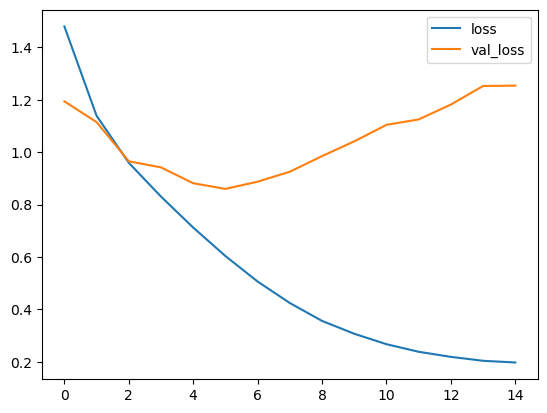

In [6]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

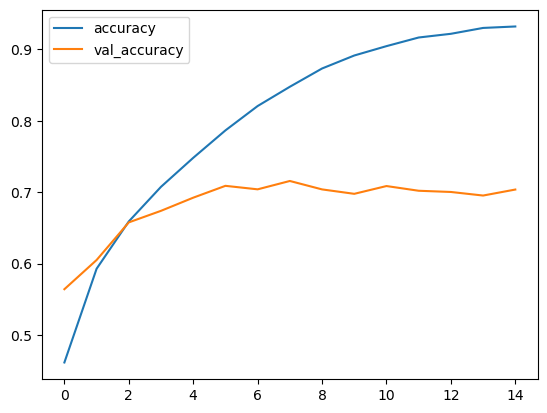

In [7]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

## 4 Perform prediction & evalute model


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

313/313 [==============================] - 1s 3ms/step


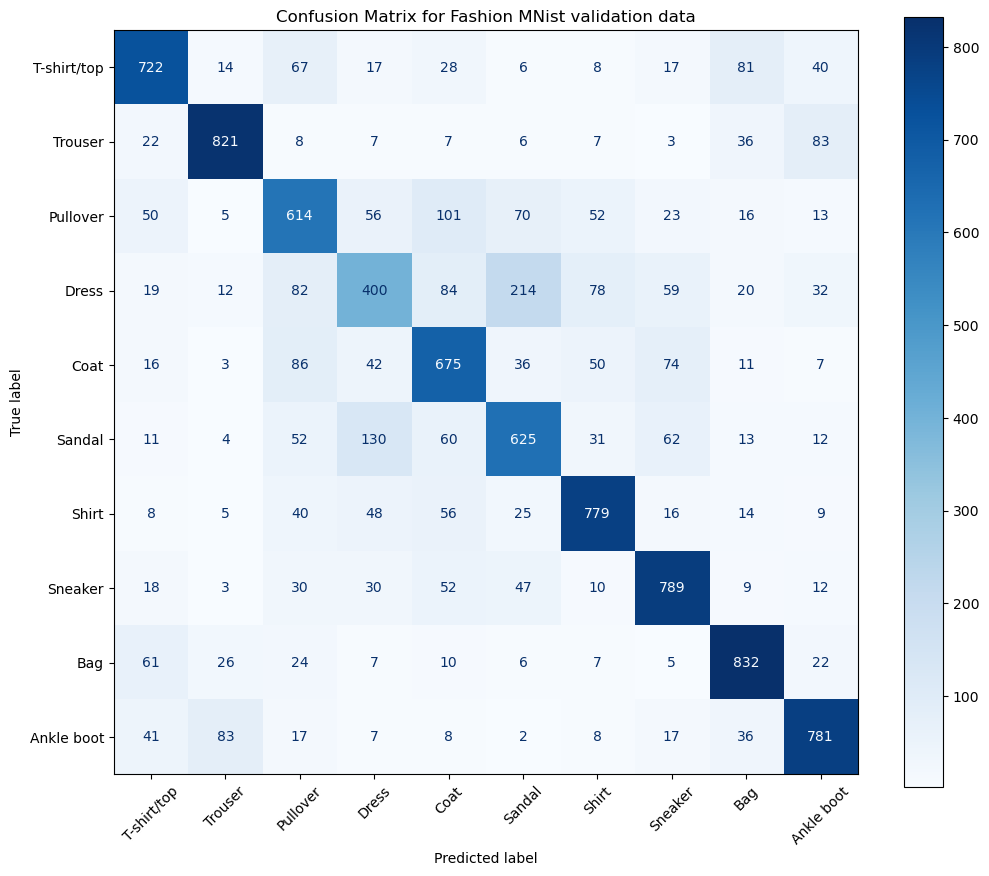

In [9]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) # convert probabilities to classes

conf_matrix = confusion_matrix(y_test, y_pred_classes, labels=range(K))
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Fashion MNist validation data")
plt.xticks(rotation=45)
plt.show()

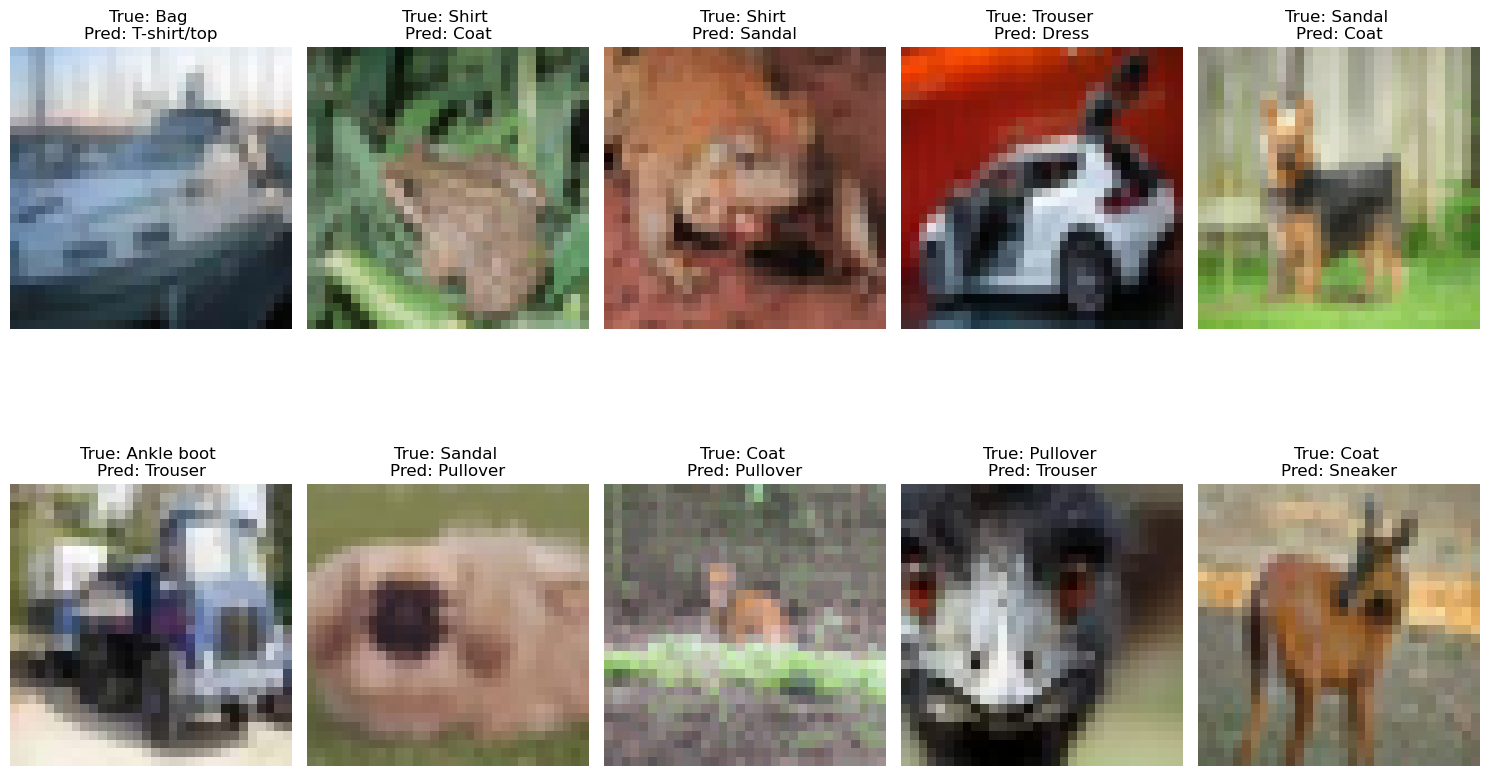

In [10]:
misclassified_idx = np.where(y_pred_classes != y_test)[0]

num_samples = 10
plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_idx[:num_samples]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f"True: {class_labels[y_test[idx]]} \nPred: {class_labels[y_pred_classes[idx]]}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

### Data Augmentation using Python generators

- generate augmented data on the fly to remove load on memory
- for each batch of data -> augment(x_batch) -> yield x_batch

#### tf.keras

- ImageDataGenerator generator object -> helps with generated augmented data on the fly
- width_shift_range | height_shift_range | horizontal_flip | vertical_flip
- rotation_range | brightness_range | shear_range | zoom_range

#### Becareful with flips

- vertical flipping of 9 becomes 6

### Batch Normalization

- to ensure that data is normalized after every Dense Layer
- normalized input data is no longer normalized after Dense layer
- BatchNorm -> Dense -> BatchNorm -> Dense -> BatchNorm -> Dense
- typically used between convolutional layers
- Conv -> BN -> Conv -> BN -> Conv -> BN -> Flatten -> Dense

#### How to know if normalization is good? And what is the optimal normalization?

- can be done through learning
- batch mean & batch std dev calculated
- subsequent values of mean & std dev can be evaluated using gradient descent
- can act as regularizer because for every batch, calculated mean and std dev will differ


### Improve Cifar10 model


In [5]:
pool_size = (2, 2)
kernel_size = (3, 3)
kernel_strides = 2 # img dimension halved after every convolution
dense_nodes = 1024

i = Input(shape=x_train[0].shape)

# VGG Network -> Multiple Conv layers before pool
# same padding to maintain output size, else after several conv layers, size will become too small
x = Conv2D(32, kernel_size, activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size)(x)

x = Conv2D(64, kernel_size, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size)(x)

x = Conv2D(128, kernel_size, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, kernel_size, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size)(x)

x = Flatten()(x) # convert image into single dimension feature vector for ANN
x = Dropout(0.2)(x) # for regularization
x = Dense(dense_nodes, activation='relu')(x)
x - Dropout(0.2)(x) # for regularization
x = Dense(K, activation='softmax')(x) # output layer

model = Model(i, x) # list / single input | list / single output


In [16]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

r = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=15
)

Epoch 1/15
1563/1563 [==============================] - 50s 32ms/step - loss: 1.2289 - accuracy: 0.5760 - val_loss: 1.0474 - val_accuracy: 0.6386
Epoch 2/15
1563/1563 [==============================] - 53s 34ms/step - loss: 0.7671 - accuracy: 0.7351 - val_loss: 0.8305 - val_accuracy: 0.7160
Epoch 3/15
1563/1563 [==============================] - 54s 34ms/step - loss: 0.6176 - accuracy: 0.7846 - val_loss: 0.6761 - val_accuracy: 0.7645
Epoch 4/15
1563/1563 [==============================] - 54s 35ms/step - loss: 0.5052 - accuracy: 0.8247 - val_loss: 0.6958 - val_accuracy: 0.7782
Epoch 5/15
1563/1563 [==============================] - 54s 35ms/step - loss: 0.4135 - accuracy: 0.8561 - val_loss: 0.8193 - val_accuracy: 0.7519
Epoch 6/15
1563/1563 [==============================] - 54s 35ms/step - loss: 0.3388 - accuracy: 0.8820 - val_loss: 0.6362 - val_accuracy: 0.8049
Epoch 7/15
1563/1563 [==============================] - 54s 34ms/step - loss: 0.2702 - accuracy: 0.9069 - val_loss: 0.6033 -

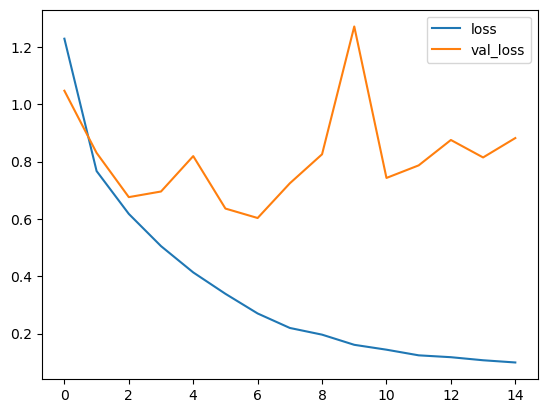

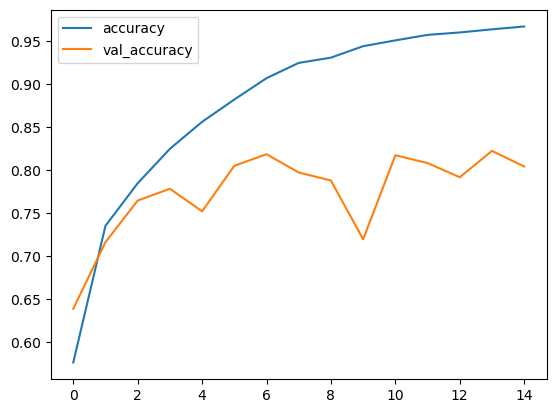

In [17]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

### Data Augmentation


In [7]:
# if run model.fit_generator after model.fit(), it will continue training with existing weights
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=.1,
    height_shift_range=.1,
    horizontal_flip=True
)

train_generator = data_generator.flow(
    x_train, y_train, batch_size
)

steps_per_epoch = x_train.shape[0] // batch_size

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

r_augment = model.fit_generator(
    train_generator,
    validation_data=(x_test, y_test),
    steps_per_epoch=steps_per_epoch,
    epochs=15
)

Epoch 1/15


/var/folders/fc/n6ycqzwx13989g40ry2djdsh0000gn/T/ipykernel_33202/2556210298.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r_augment = model.fit_generator(


1562/1562 [==============================] - 45s 29ms/step - loss: 1.3684 - accuracy: 0.5249 - val_loss: 1.2481 - val_accuracy: 0.5985
Epoch 2/15
1562/1562 [==============================] - 55s 35ms/step - loss: 0.8985 - accuracy: 0.6858 - val_loss: 0.7856 - val_accuracy: 0.7299
Epoch 3/15
1562/1562 [==============================] - 56s 36ms/step - loss: 0.7679 - accuracy: 0.7350 - val_loss: 0.8147 - val_accuracy: 0.7280
Epoch 4/15
1562/1562 [==============================] - 55s 35ms/step - loss: 0.6862 - accuracy: 0.7620 - val_loss: 0.7312 - val_accuracy: 0.7482
Epoch 5/15
1562/1562 [==============================] - 60s 39ms/step - loss: 0.6206 - accuracy: 0.7860 - val_loss: 0.6474 - val_accuracy: 0.7793
Epoch 6/15
1562/1562 [==============================] - 60s 38ms/step - loss: 0.5789 - accuracy: 0.8007 - val_loss: 0.7257 - val_accuracy: 0.7640
Epoch 7/15
1562/1562 [==============================] - 59s 38ms/step - loss: 0.5400 - accuracy: 0.8169 - val_loss: 0.7254 - val_accura

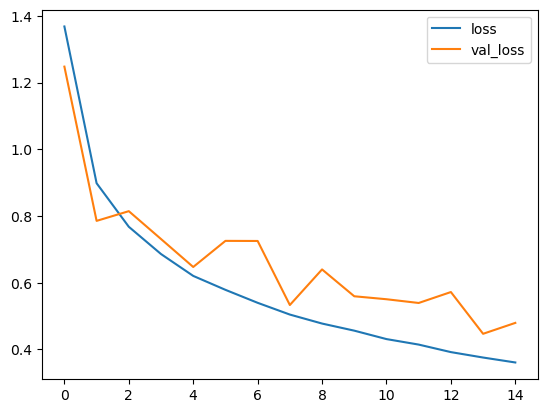

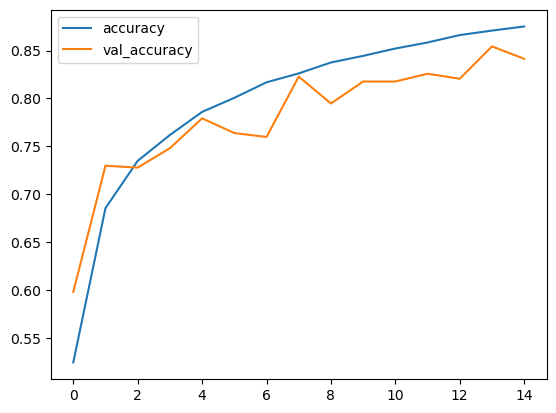

In [8]:
plt.plot(r_augment.history['loss'], label='loss')
plt.plot(r_augment.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(r_augment.history['accuracy'], label='accuracy')
plt.plot(r_augment.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

313/313 [==============================] - 5s 16ms/step


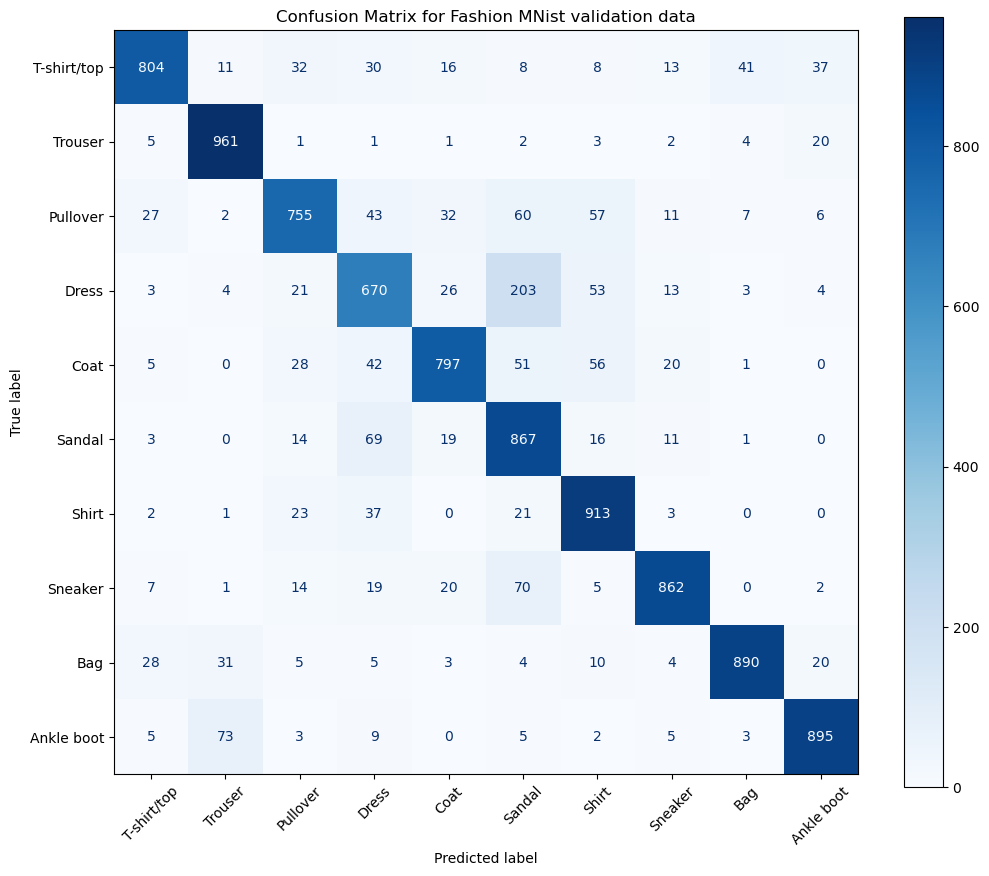

In [10]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) # convert probabilities to classes

conf_matrix = confusion_matrix(y_test, y_pred_classes, labels=range(K))
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Fashion MNist validation data")
plt.xticks(rotation=45)
plt.show()

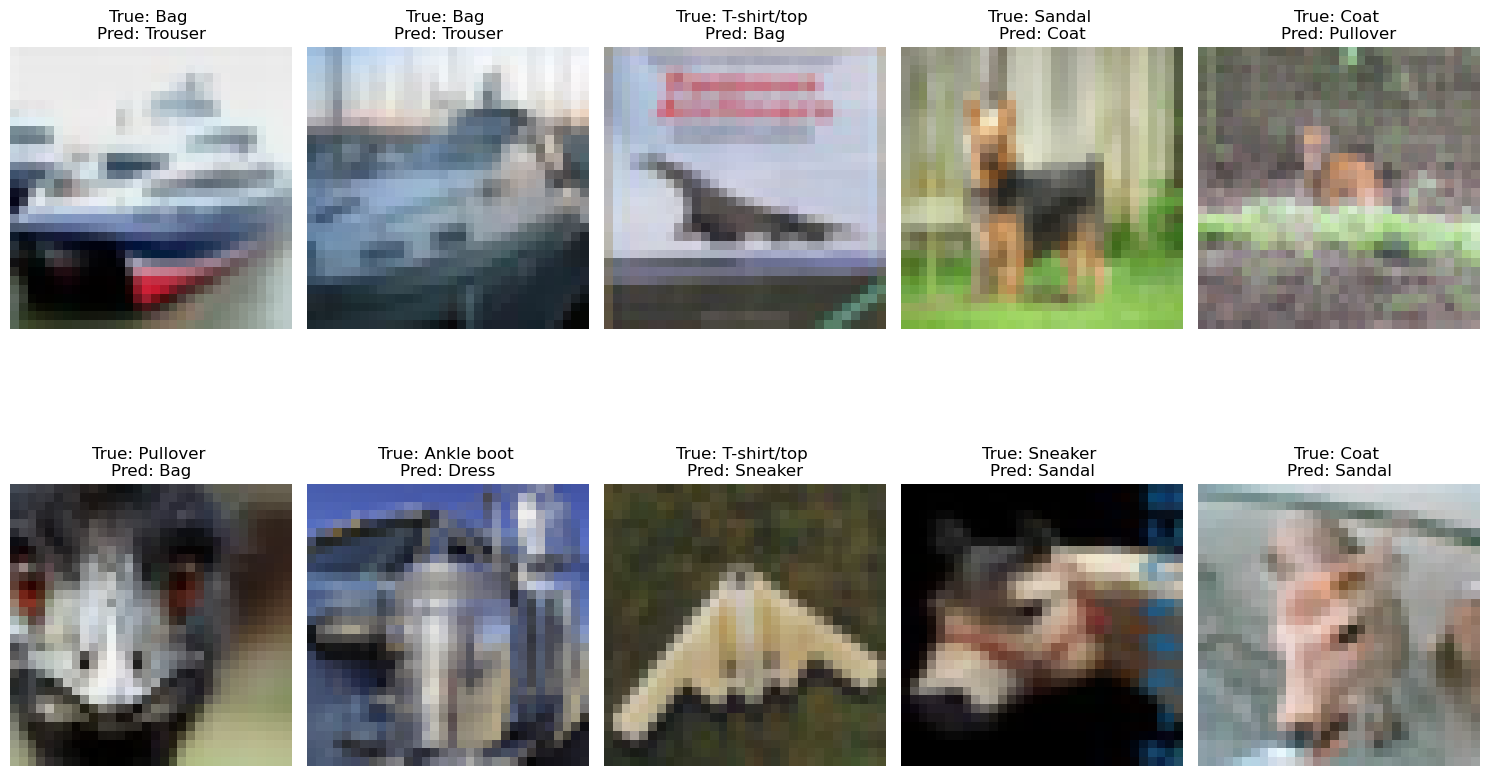

In [11]:
misclassified_idx = np.where(y_pred_classes != y_test)[0]

num_samples = 10
plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_idx[:num_samples]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f"True: {class_labels[y_test[idx]]} \nPred: {class_labels[y_pred_classes[idx]]}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()